In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from tqdm import tqdm

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit  #This helps me stratify the data into test and train datasets, with equal class proportions
from sklearn.utils import resample

In [ ]:
data = pd.read_csv('train.csv')
testData= pd.read_csv('test.csv')

In [ ]:
# Separate the features (X) and target variable (y)
X = data.drop(['id', 'NObeyesdad'], axis=1)
y = data['NObeyesdad']


In [ ]:
categorical_features = ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']
X = pd.get_dummies(X, columns=categorical_features)

In [ ]:
categoryToIndex = {'Overweight_Level_II':0, 'Normal_Weight':1, 'Insufficient_Weight':2,
       'Obesity_Type_III':3, 'Obesity_Type_II':4, 'Overweight_Level_I':5,
       'Obesity_Type_I':6}


In [ ]:
 y = y.map(categoryToIndex).values

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=1337)
X_train = []; y_train = []; X_test = []; y_test = []
for train_idx, test_idx in sss.split(X, y):
    X_train = X.iloc[train_idx,:]
    y_train = y[train_idx]
    X_test = X.iloc[test_idx,:]
    y_test = y[test_idx]


In [ ]:
#So now X is a pd df, with one hot encoding for all the class data. y is now a integer encoding
#of the labels. Furthermore the train and test data sets have equal proportions of the classes.

In [ ]:
#Put data on tensors. If wanting to run this on GPU, then convert to(device)
X_train = torch.tensor(X_train.values.astype(float), dtype=torch.float32)#.to(device) # Features
y_train = torch.tensor(y_train, dtype=torch.long)#.to(device)  # Targets (for classification)
X_test = torch.tensor(X_test.values.astype(float), dtype=torch.float32)#.to(device) # Features
y_test = torch.tensor(y_test, dtype=torch.long)#.to(device)  # Targets (for classification)


In [ ]:
# Create dataset
trainDataset = TensorDataset(X_train, y_train)
testDataset = TensorDataset(X_test, y_test)

In [ ]:
# Create data loader. I add total_items attr so that the train function can access them later
batchSize = 32
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
trainLoader.total_items = len(X_train)
trainLoader.batchSize = batchSize
testLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=True)
testLoader.total_items = len(X_test)
testLoader.batchSize = batchSize

In [ ]:
#Defining a basic model,
class Multiclass(nn.Module):
    def __init__(self, hiddenLayerSize, numLayers):
        super().__init__()
        self.hidden = nn.ModuleList()
        self.numLayers = numLayers
        self.hiddenLayerSize = hiddenLayerSize

        if (numLayers == 1):
            self.hidden.append(nn.Linear(X.shape[-1], hiddenLayerSize))
        elif (numLayers > 1):
            self.hidden.append(nn.Linear(X.shape[-1], hiddenLayerSize))
            for x in range(numLayers - 1):
                self.hidden.append(nn.Linear(hiddenLayerSize, hiddenLayerSize))

        self.act = nn.ReLU()
        self.output = nn.Linear(hiddenLayerSize, len(categoryToIndex))

    def forward(self, x):
        for layer in self.hidden:
            x = self.act(layer(x))
        x = self.output(x)
        return x
    def resetParameters(self):
        for layer in self.hidden:
            layer.reset_parameters()
        self.output.reset_parameters()

In [ ]:
model = Multiclass(60,2)

In [ ]:
# training parameters
def train(model, trainLoader, testLoader, n_epochs,print=True,show_epochs=False,saveModel=False):
    trainLosses = []
    trainAccuracy = []
    testLosses = []
    testAccuracy = []
    bestTestAccuracy = 0
    bestEpoch = 0
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        trainLosses.append(0)
        trainAccuracy.append(0)
        for inputs, labels in tqdm(trainLoader, total=len(trainLoader), desc=f"Epoch {epoch+1}/{n_epochs}",disable= not show_epochs):

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the running loss
            trainLosses[-1] += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            trainAccuracy[-1] += (predicted == labels).sum().item()
        testLosses.append(0)
        testAccuracy.append(0)
        for inputs, labels in tqdm(testLoader, total=len(testLoader), desc=f"Epoch {epoch+1}/{n_epochs}",disable= not show_epochs):

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Update the running loss
            testLosses[-1] += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            testAccuracy[-1] += (predicted == labels).sum().item()

        # Compute epoch-wise loss and accuracy
        trainLosses[-1] = trainLosses[-1] /len(trainLoader)
        trainAccuracy[-1] = 100 * trainAccuracy[-1] / trainLoader.total_items
        testLosses[-1] = testLosses[-1] / len(testLoader)
        testAccuracy[-1] = 100 * testAccuracy[-1] / testLoader.total_items

        if (testAccuracy[-1] > bestTestAccuracy):
                bestTestAccuracy = testAccuracy[-1]
                bestEpoch = epoch
                if saveModel:
                    torch.save(model.state_dict(), f'{saveModel}.pth')  # Save the model state

    if (print):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        ax1.plot(trainAccuracy,label = "Training Accuracy", c='r')
        ax1.plot(testAccuracy,label = "Test Accuracy", c='b')
        ax1.set_title(f'Accuracy vs. Epochs, ReLU with {model.numLayers} layers of size {model.hiddenLayerSize}')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy (%)')

        ax2.plot(trainLosses,label = "Training Losses", c='r')
        ax2.plot(testLosses,label = "Test Losses", c='b')
        ax2.set_title('Loss vs. Epochs')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')

        plt.tight_layout()
        plt.show()
    return (trainLosses, trainAccuracy, testLosses, testAccuracy, bestTestAccuracy, bestEpoch)

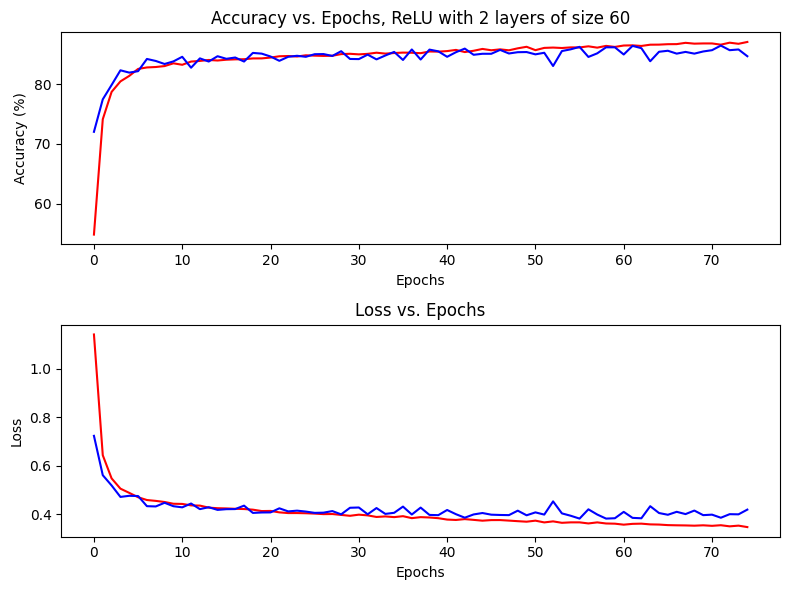

In [ ]:
model.resetParameters()
trainLosses, trainAccuracy, testLosses, testAccuracy, bestTestAccuracy, bestEpoch = train(model, trainLoader, testLoader, 75, show_epochs=False)

In [ ]:
sizes = [1, 2, 4, 8, 16, X.shape[-1], 2 * X.shape[-1], 4 * X.shape[-1]]
layers = [1, 2, 3]
accuracies = np.zeros((len(sizes),len(layers)))
overfitting = np.zeros((len(sizes),len(layers)))
convergenceEpoch = np.zeros((len(sizes),len(layers)))
for i, layerSize in enumerate(sizes):
    for j, numLayers in enumerate(layers):
        model = Multiclass(layerSize,numLayers)
        #
        # This is a very long hyper parameter search for the optimal layer size. I let each test go past convergence so I can also get an understanding of how each model overfits
        #I commented out the search loop and included the graphs in the text cells below
        #
        #trainLosses, trainAccuracy, testLosses, testAccuracy, bestTestAccuracy, bestEpoch = train(model, trainLoader, testLoader, 50, print=False)
        #accuracies[i][j] = bestTestAccuracy
        #overfitting[i][j] = np.mean(trainAccuracy[-5:]) - np.mean(testAccuracy[-5:])
        #convergenceEpoch[i][j] = bestEpoch

<ipython-input-21-35eb4c180356>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+sizes)


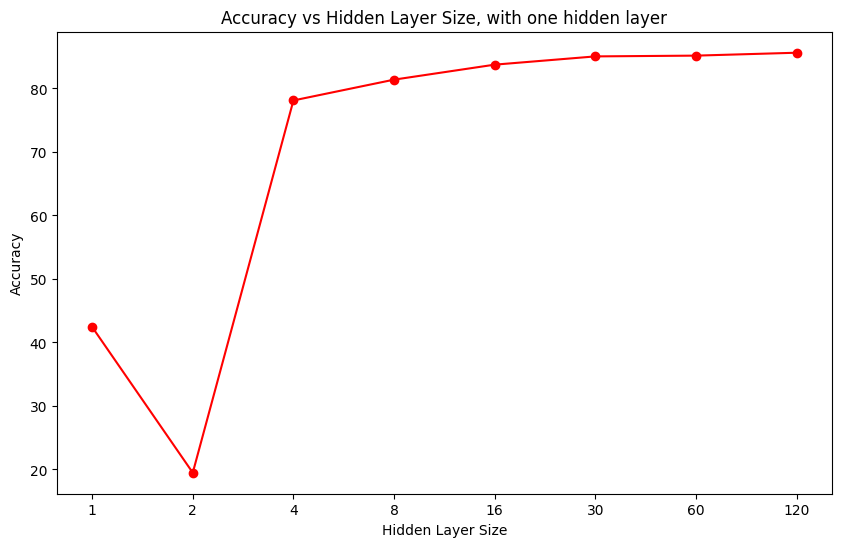

In [ ]:
if accuracies[0,0] != 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(len(sizes)),accuracies[:,0],marker='o',c='r')
    ax.set_title("Accuracy vs Hidden Layer Size, with one hidden layer")
    ax.set_xticklabels([0]+sizes)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Hidden Layer Size')
    plt.show()


![AccuracyVsLayerSize.png](
  ![Hidden Layers Vs accuracy.png](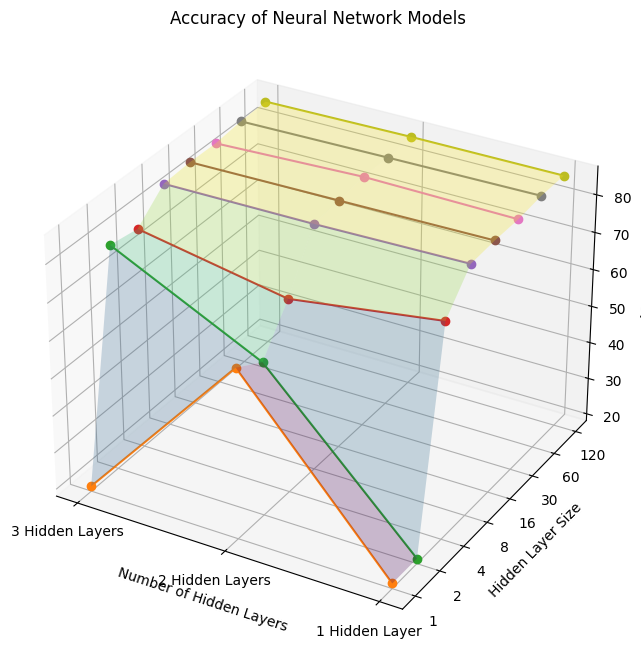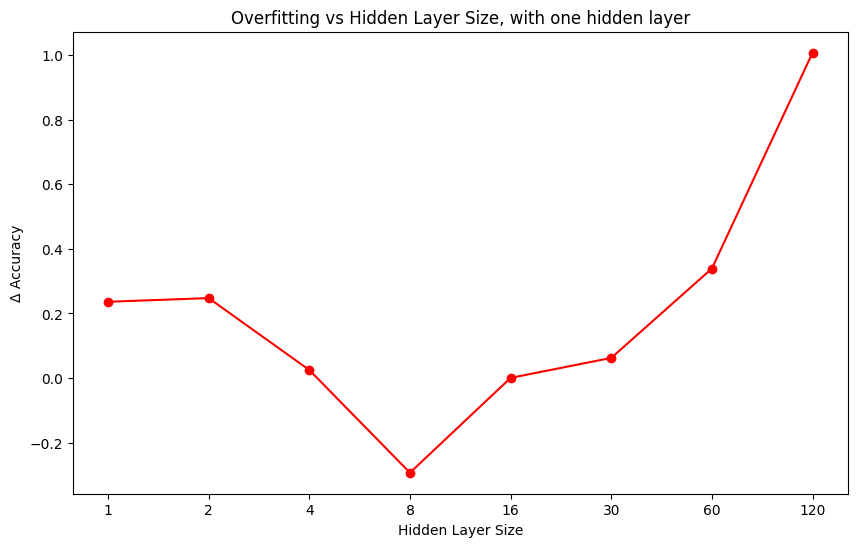)
)

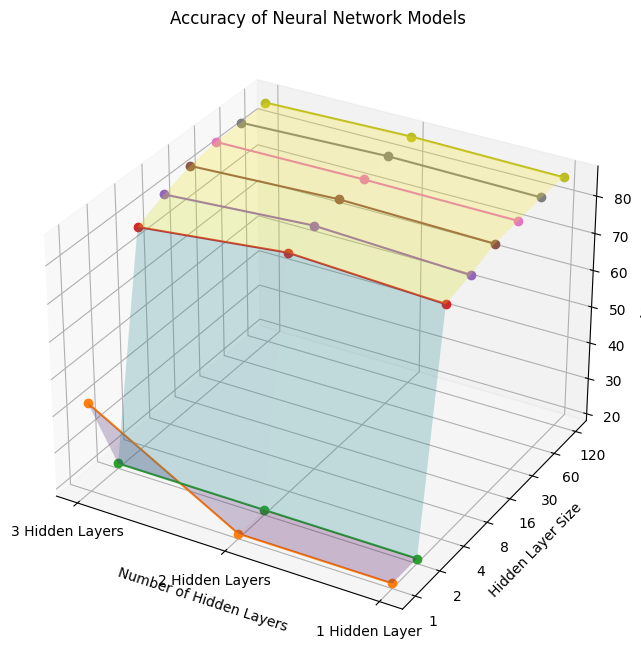

In [ ]:
if accuracies[0,0] != 0:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    x, y = np.meshgrid(range(1, 4), range(len(sizes)))
    z = accuracies

    ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',alpha=.25)
    for i in range(accuracies.shape[0]):
        ax.plot(range(1, 4),accuracies[i], zs=i, zdir='y',marker='o', label=f'Hidden Layer Size: {sizes[i]}')



    ax.set_title('Accuracy of Neural Network Models')
    ax.set_xlabel('Number of Hidden Layers')
    ax.set_ylabel('Hidden Layer Size')
    ax.set_zlabel('Accuracy')
    ax.set_xticks((3,2,1))
    ax.set_xticklabels(['1 Hidden Layer', '2 Hidden Layers', '3 Hidden Layers'])
    ax.set_yticks(range(len(sizes)))
    ax.set_yticklabels([str(size) for size in sizes])

    plt.show()

![Hidden Layers Vs accuracy.png](
  
)

<ipython-input-23-923704de0264>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+sizes)


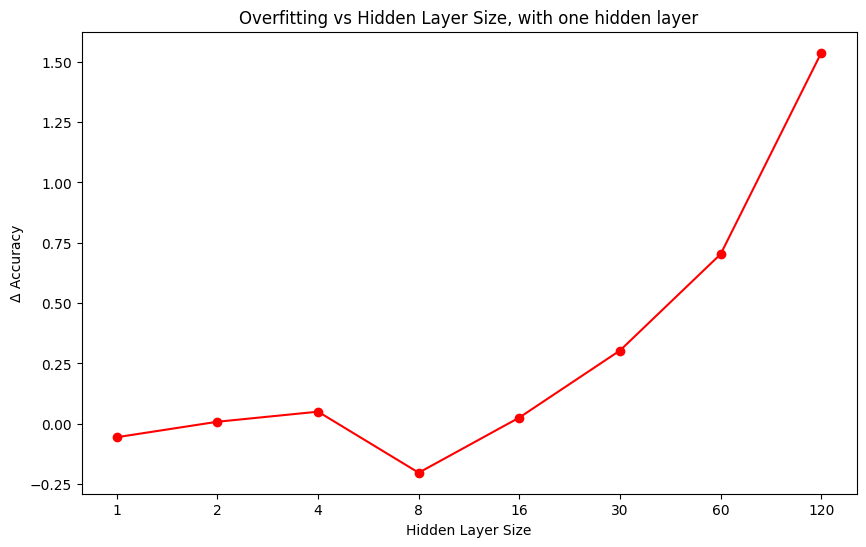

In [ ]:
if accuracies[0,0] != 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(len(sizes)),np.mean(overfitting,axis=1),marker='o',c='r')
    ax.set_title("Overfitting vs Hidden Layer Size, with one hidden layer")
    ax.set_xticklabels([0]+sizes)
    ax.set_ylabel(u'Δ Accuracy')
    ax.set_xlabel('Hidden Layer Size')
    plt.show()


![Overfitting vs hidden layer size.png]

In [ ]:
#Now I felt 2 layers with 60 neurons each would be a good middle ground between accuracy and overfitting, I started to research how class proportion was affecting accuracy.

In [ ]:
# Separate majority and minority classes
minorityClass0 = data[data['NObeyesdad'] == 'Obesity_Type_III']
minorityClass1 = data[data['NObeyesdad'] == 'Obesity_Type_II']
minorityClass2 = data[data['NObeyesdad'] == 'Normal_Weight']
minorityClass3 = data[data['NObeyesdad'] == 'Obesity_Type_I']
minorityClass4 = data[data['NObeyesdad'] == 'Insufficient_Weight']
minorityClass5 = data[data['NObeyesdad'] == 'Overweight_Level_II']
minorityClass6 = data[data['NObeyesdad'] == 'Overweight_Level_I']

# Resample classs to match the count of the smallest class
minorityClass0Downsampled = resample(minorityClass0, replace=False, n_samples=len(minorityClass6))
minorityClass1Downsampled = resample(minorityClass1, replace=False, n_samples=len(minorityClass6))
minorityClass2Downsampled = resample(minorityClass2, replace=False, n_samples=len(minorityClass6))
minorityClass3Downsampled = resample(minorityClass3, replace=False, n_samples=len(minorityClass6))
minorityClass4Downsampled = resample(minorityClass4, replace=False, n_samples=len(minorityClass6))
minorityClass5Downsampled = resample(minorityClass5, replace=False, n_samples=len(minorityClass6))
minorityClass6Downsampled = resample(minorityClass6, replace=False, n_samples=len(minorityClass6))

# Combine resampled majority class with minority classes
balancedData = pd.concat([minorityClass0Downsampled,
                           minorityClass1Downsampled,
                           minorityClass2Downsampled,
                           minorityClass3Downsampled,
                           minorityClass4Downsampled,
                           minorityClass5Downsampled,
                           minorityClass6Downsampled])

In [ ]:
# Separate the features (X) and target variable (y)
X_equal = balancedData.drop(['id', 'NObeyesdad'], axis=1)
y_equal = balancedData['NObeyesdad']

X_equal = pd.get_dummies(X_equal, columns=categorical_features)
y_equal = y_equal.map(categoryToIndex).values

sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=1337)
X_equal_train = []; y_equal_train = []; X_equal_test = []; y_equal_test = []
for train_idx, test_idx in sss.split(X_equal, y_equal):
    X_equal_train = X_equal.iloc[train_idx,:]
    y_equal_train = y_equal[train_idx]
    X_equal_test = X_equal.iloc[test_idx,:]
    y_equal_test = y_equal[test_idx]

In [ ]:
unique, counts = np.unique(y_equal_test, return_counts=True)
np.asarray((unique, counts)).T
#Thus each class is now equally represented

array([[  0, 486],
       [  1, 485],
       [  2, 485],
       [  3, 485],
       [  4, 486],
       [  5, 486],
       [  6, 485]])

In [ ]:
# Separate features and targets
X_equal_train = torch.tensor(X_equal_train.values.astype(float), dtype=torch.float32)#.to(device) # Features
y_equal_train = torch.tensor(y_equal_train, dtype=torch.long)#.to(device)  # Targets (for classification)
X_equal_test = torch.tensor(X_equal_test.values.astype(float), dtype=torch.float32)#.to(device) # Features
y_equal_test = torch.tensor(y_equal_test, dtype=torch.long)#.to(device)  # Targets (for classification)

# Create dataset
trainEqualDataset = TensorDataset(X_equal_train, y_equal_train)
testEqualDataset = TensorDataset(X_equal_test, y_equal_test)

# Create data loader
trainEqualLoader = DataLoader(trainEqualDataset, batch_size=batchSize, shuffle=True)
testEqualLoader = DataLoader(testEqualDataset, batch_size=batchSize, shuffle=True)
trainEqualLoader.total_items = len(X_equal_train)
trainEqualLoader.batchSize = batchSize
testEqualLoader.total_items = len(X_equal_test)
testEqualLoader.batchSize = batchSize

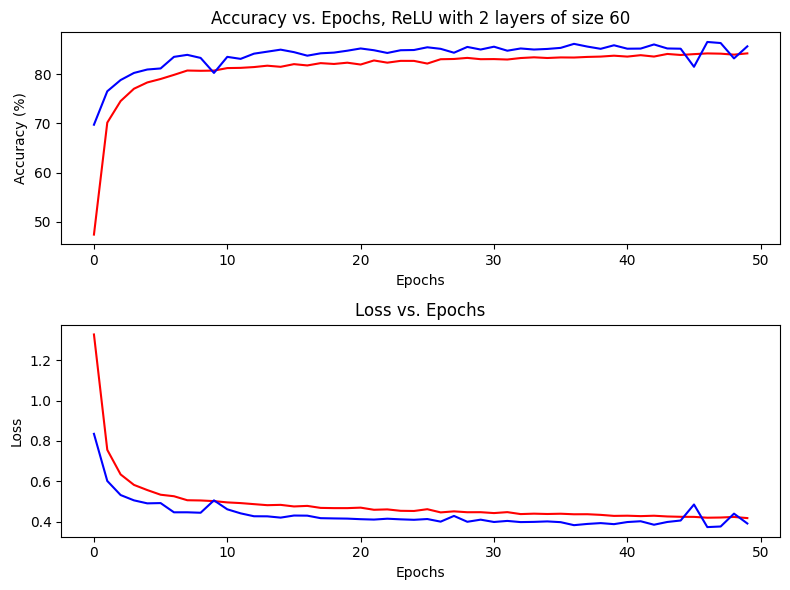

In [ ]:
model = Multiclass(60,2)
trainEqualLosses, trainEqualAccuracy, testEqualLosses, testEqualAccuracy, bestEqualTestAccuracy, bestEqualEpoch = train(model, trainEqualLoader, testLoader, 50, show_epochs=False,saveModel="equalClasses50Epoch")
#So when we train on the equally proportioned data, but test on the unequal data, we get a rare occurence of test acccuracy being higher than train accuracy accross the board.
#This implies to me I should increase the number of epochs

In [ ]:
equalModelAccuracyOnStandardData = 0
model.load_state_dict(torch.load(f'equalClasses50Epoch.pth'))
for inputs, labels in tqdm(testLoader, total=len(testLoader),disable=True):
    loss_fn = nn.CrossEntropyLoss()
    # Forward pass
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    equalModelAccuracyOnStandardData += (predicted == labels).sum().item()

  # Compute epoch-wise loss and accuracy
equalModelAccuracyOnStandardData = 100 * equalModelAccuracyOnStandardData / testLoader.total_items
equalModelAccuracyOnStandardData


86.60886319845858

In [ ]:
equalModelAccuracyOnStandardData - bestTestAccuracy #So I get about a 1 percent accuracy boost from training on equal proportions

0.5057803468208135

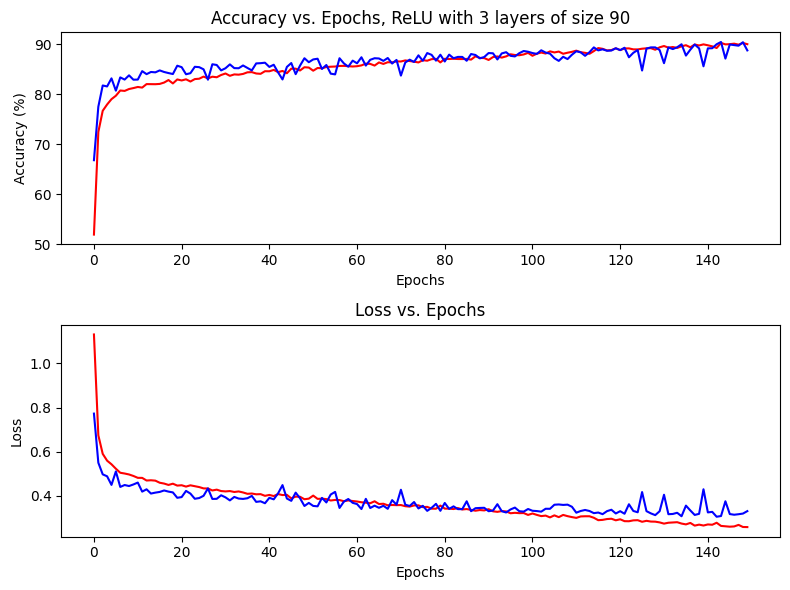

In [ ]:
#So when we train on the equally proportioned data, but test on the unequal data, we get a rare occurence of test acccuracy being higher than train accuracy accross the board.
#This implies to me I should increase the number of epochs
model = Multiclass(90,3)
trainEqualLosses, trainEqualAccuracy, testEqualLosses, testEqualAccuracy, bestEqualTestAccuracy3Layer, bestEqualEpoch = train(model, trainEqualLoader, testLoader, 150, show_epochs=False,saveModel="equalClasses150Epoch")


In [ ]:
#This is the highest accuracy epoch of the network, on the test data
bestEqualTestAccuracy3Layer

90.41425818882466

In [ ]:
bestEqualTestAccuracy3Layer - bestTestAccuracy #So utilyzing the fact that changing the proportions lessens the "overfittablity" to the data, our model can better learn the data.

4.311175337186896

Knowing that dropout also decreases "overfittability" of the data, I then sought to see the effect of dropout.

In [ ]:
#Defining a basic model with dropout
class Multiclass(nn.Module):
    def __init__(self, hiddenLayerSize, numLayers, dropout=.2):
        super().__init__()
        self.hidden = nn.ModuleList()
        self.numLayers = numLayers
        self.hiddenLayerSize = hiddenLayerSize

        self.dropout = nn.Dropout(dropout)

        self.hidden.append(nn.Linear(X.shape[-1], hiddenLayerSize))
        self.hidden.append(nn.Linear(hiddenLayerSize, hiddenLayerSize))
        self.hidden.append(nn.Linear(hiddenLayerSize, hiddenLayerSize))

        self.act = nn.ReLU()
        self.output = nn.Linear(hiddenLayerSize, len(categoryToIndex))

    def forward(self, x):
        x = self.act(self.hidden[0](x))
        x = self.dropout(x)
        x = self.act(self.hidden[1](x))
        x = self.act(self.hidden[2](x))
        x = self.output(x)
        return x
    def resetParameters(self):
        for layer in self.hidden:
            layer.reset_parameters()
        self.output.reset_parameters()

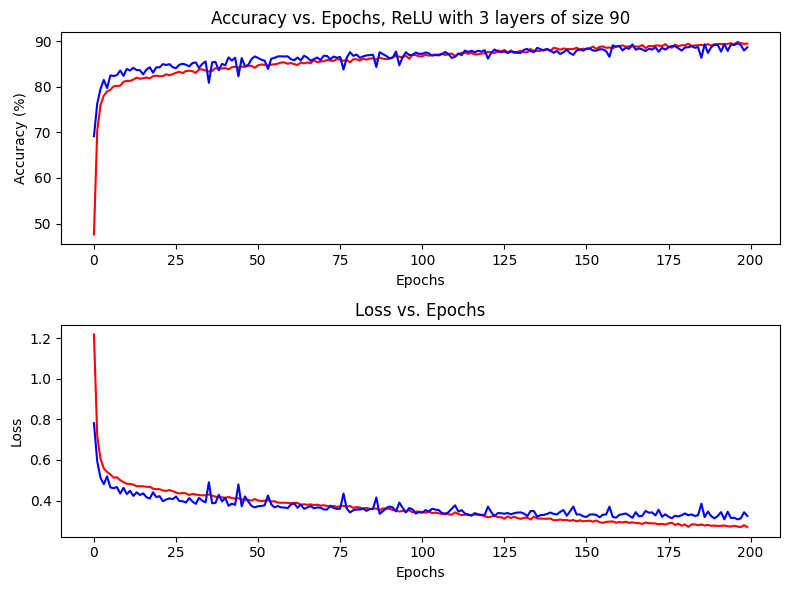

In [ ]:
model = Multiclass(90,3,0.05) #I found any amount of drop out decreased accuracy
trainDropoutLosses, trainDropoutAccuracy, testDropoutLosses, testDropoutAccuracy, bestDropoutlTestAccuracy, bestDropoutEpoch = train(model, trainEqualLoader, testLoader, 200, show_epochs=False,saveModel="Dropout200Epoch")


While not shown, I changed the model parameters by hand. Training with dropout  slowed the learning, so I ended up increasing the epochs to 200. Ultimately The highest accuracy was lower than that of just the equal proportion. From here I decided to use the 3 layer model with no dropout and assign labels to the kaggle test data, and upload it and see my accuracy on the kaggle provided validation data.

In [ ]:
#Defining a basic model with dropout
class Multiclass(nn.Module):
    def __init__(self, hiddenLayerSize, numLayers):
        super().__init__()
        self.hidden = nn.ModuleList()
        self.numLayers = numLayers
        self.hiddenLayerSize = hiddenLayerSize

        self.hidden.append(nn.Linear(X.shape[-1], hiddenLayerSize))
        self.hidden.append(nn.Linear(hiddenLayerSize, hiddenLayerSize))
        self.hidden.append(nn.Linear(hiddenLayerSize, hiddenLayerSize))

        self.act = nn.ReLU()
        self.output = nn.Linear(hiddenLayerSize, len(categoryToIndex))

    def forward(self, x):
        x = self.act(self.hidden[0](x))
        x = self.act(self.hidden[1](x))
        x = self.act(self.hidden[2](x))
        x = self.output(x)
        return x
    def resetParameters(self):
        for layer in self.hidden:
            layer.reset_parameters()
        self.output.reset_parameters()

#model = Multiclass(90,3)
model.load_state_dict(torch.load(f'equalClasses100Epoch.pth'))

<All keys matched successfully>

In [ ]:
X_validation = testData.drop(['id'], axis=1)
X_validation = pd.get_dummies(X_validation, columns=categorical_features).drop(['CALC_Always'], axis=1) #Oddly the validation data has a categorical value in 2 datapoints that isn't in the rest of the data. So I drop this one shot column
X_validation = torch.tensor(X_validation.values.astype(float), dtype=torch.float32)

In [ ]:
estimates = model(X_validation)

In [ ]:
predictedLabelIndexs = torch.argmax(estimates, dim=1)

In [ ]:
labels = pd.Series(predictedLabelIndexs)

In [ ]:
indexToCategory = {0:'Overweight_Level_II', 1:'Normal_Weight', 2:'Insufficient_Weight',
       3:'Obesity_Type_III', 4:'Obesity_Type_II', 5:'Overweight_Level_I',
       6:'Obesity_Type_I'}


In [ ]:
labels = labels.map(indexToCategory)
labels.name = 'NObeyesdad'

In [ ]:
joined_data = pd.concat([testData, labels], axis=1)

In [ ]:
joined_data = joined_data[['id','NObeyesdad']]
joined_data

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_II
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Overweight_Level_I
13837,34595,Insufficient_Weight
13838,34596,Insufficient_Weight


In [ ]:
joined_data.to_csv('daxs_data.csv', index=False)
#Then testing this on kaggle I got 86.9% for my validation testing

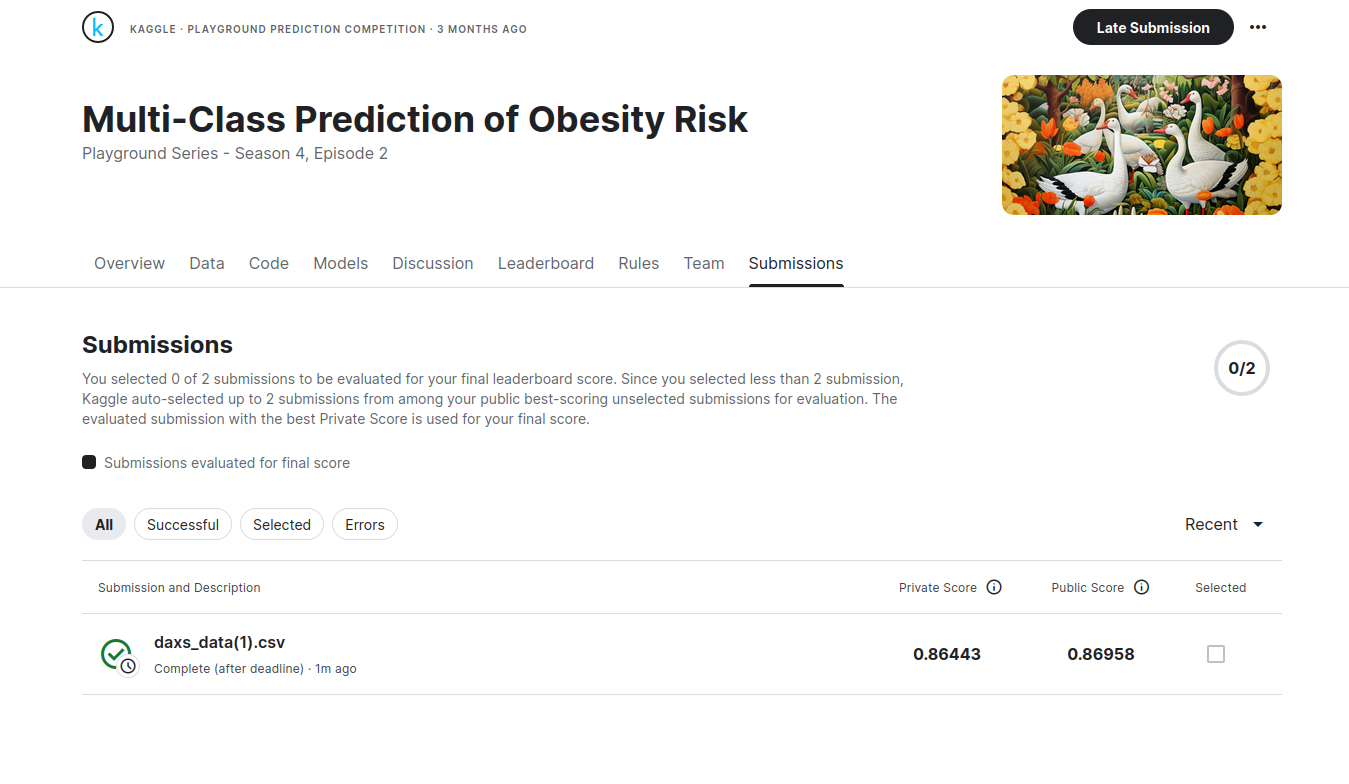